In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from sklearn.impute import SimpleImputer as Imputer

In [2]:
flight_data = pd.read_csv("FLIGHTS.csv")

In [3]:
pd.set_option("display.max_columns", None)
flight_data.head()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,MKT_CARRIER_AIRLINE_ID,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY_NEW,DEP_DEL15,DEP_DELAY_GROUP,ARR_TIME,ARR_DELAY_NEW,ARR_DEL15,ARR_DELAY_GROUP,CANCELLED,CANCELLATION_CODE,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,index
0,2024,1,1,1,1,19393,10140,1014005,"Albuquerque, NM",10423,1042302,"Austin, TX",700,707.0,7.0,0.0,0.0,950.0,15.0,1.0,1.0,0.0,NaN,95.0,103.0,619.0,7.0,0.0,8.0,0.0,0.0,0
1,2024,1,1,1,1,19393,10140,1014005,"Albuquerque, NM",10423,1042302,"Austin, TX",1830,1826.0,0.0,0.0,-1.0,2112.0,2.0,0.0,0.0,0.0,NaN,100.0,106.0,619.0,0.0,0.0,0.0,0.0,0.0,1
2,2024,1,1,1,1,19393,10140,1014005,"Albuquerque, NM",10800,1080003,"Burbank, CA",1420,1426.0,6.0,0.0,0.0,1516.0,0.0,0.0,-1.0,0.0,NaN,130.0,110.0,672.0,0.0,0.0,0.0,0.0,0.0,2
3,2024,1,1,1,1,19393,10140,1014005,"Albuquerque, NM",10821,1082106,"Baltimore, MD",1500,1514.0,14.0,0.0,0.0,2050.0,15.0,1.0,1.0,0.0,NaN,215.0,216.0,1670.0,14.0,0.0,1.0,0.0,0.0,3
4,2024,1,1,1,1,19393,10140,1014005,"Albuquerque, NM",11259,1125904,"Dallas, TX",530,527.0,0.0,0.0,-1.0,805.0,0.0,0.0,-1.0,0.0,NaN,105.0,98.0,580.0,0.0,0.0,0.0,0.0,0.0,4


In [12]:
clusters_data = pd.read_csv("data_with_clusters.csv")

In [13]:
import pandas as pd

df = flight_data.copy()

possible_aircraft_cols = ["TAIL_NUM", "AIRCRAFT_ID", "ACFT_ID", "N_NUMBER"]
aircraft_candidates = [c for c in possible_aircraft_cols if c in df.columns]

if aircraft_candidates:
    aircraft_col = aircraft_candidates[0]
else:
    aircraft_col = "MKT_CARRIER_AIRLINE_ID"

dep_time_str = df["CRS_DEP_TIME"].astype(int).astype(str).str.zfill(4)
dep_hour = dep_time_str.str[:2].astype(int)
dep_min = dep_time_str.str[2:].astype(int)

dep_date = pd.to_datetime(
    {
        "year": df["YEAR"],
        "month": df["MONTH"],
        "day": df["DAY_OF_MONTH"],
    }
)

df["CRS_DEP_DT"] = dep_date + pd.to_timedelta(dep_hour, unit="h") + pd.to_timedelta(dep_min, unit="m")

df = df.sort_values([aircraft_col, "CRS_DEP_DT"])

g = df.groupby(aircraft_col, group_keys=False)

df["prev_dest_airport"] = g["DEST_AIRPORT_ID"].shift(1)
df["prev_dep_dt"] = g["CRS_DEP_DT"].shift(1)

df["prev_real_delay"] = (
    g["CARRIER_DELAY"].shift(1).fillna(0) +
    g["WEATHER_DELAY"].shift(1).fillna(0) +
    g["NAS_DELAY"].shift(1).fillna(0) +
    g["SECURITY_DELAY"].shift(1).fillna(0) +
    g["LATE_AIRCRAFT_DELAY"].shift(1).fillna(0)
)

df["hours_since_prev"] = (df["CRS_DEP_DT"] - df["prev_dep_dt"]).dt.total_seconds() / 3600

cond_same_route = df["prev_dest_airport"].eq(df["ORIGIN_AIRPORT_ID"])
cond_within_1h = df["hours_since_prev"].between(0, 1)
cond_prev_delayed = df["prev_real_delay"] > 0

df["lagged_delay_flag"] = (cond_same_route & cond_within_1h & cond_prev_delayed).astype(int)
df["lag_delay_minutes"] = df["prev_real_delay"].where(df["lagged_delay_flag"] == 1, 0)

df = df.sort_index()

flight_data["CRS_DEP_DT"] = df["CRS_DEP_DT"]
flight_data["lagged_delay_flag"] = df["lagged_delay_flag"]
flight_data["lag_delay_minutes"] = df["lag_delay_minutes"]

sample_lagged = flight_data[flight_data["lagged_delay_flag"] == 1].head(20)

if not sample_lagged.empty:
    idx = sample_lagged.index[0]
    carrier = flight_data.loc[idx, "MKT_CARRIER_AIRLINE_ID"]
    y = flight_data.loc[idx, "YEAR"]
    m = flight_data.loc[idx, "MONTH"]
    d = flight_data.loc[idx, "DAY_OF_MONTH"]

    same_group = flight_data[
        (flight_data["MKT_CARRIER_AIRLINE_ID"] == carrier) &
        (flight_data["YEAR"] == y) &
        (flight_data["MONTH"] == m) &
        (flight_data["DAY_OF_MONTH"] == d)
    ].sort_values("CRS_DEP_DT")

    same_group[[
        "ORIGIN_AIRPORT_ID",
        "DEST_AIRPORT_ID",
        "CRS_DEP_DT",
        "ARR_DELAY_NEW",
        "CARRIER_DELAY",
        "WEATHER_DELAY",
        "NAS_DELAY",
        "SECURITY_DELAY",
        "LATE_AIRCRAFT_DELAY",
        "lagged_delay_flag",
        "lag_delay_minutes"
    ]]
clusters_data["prev_real_delay"] = df["prev_real_delay"] 
clusters_data["lagged_delay_flag"] = df["lagged_delay_flag"]

In [14]:
clusters_data.head()

,YEAR,QUARTER,MONTH,DAY,DAY_OF_WEEK,MKT_CARRIER_AIRLINE_ID,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY_NEW,DEP_DEL15,DEP_DELAY_GROUP,ARR_TIME,ARR_DELAY_NEW,ARR_DEL15,ARR_DELAY_GROUP,CANCELLED,CANCELLATION_CODE,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,index,FL_DATE,origin_flights_day,origin_bucket,dest_flights_day,destination_bucket,distance_bucket,airline_bucket,prev_real_delay,lagged_delay_flag
0,2024,1,1,1,1,19393,10140,1014005,"Albuquerque, NM",10423,1042302,"Austin, TX",700,707.0,7.0,0.0,0.0,950.0,15.0,1.0,1.0,0.0,NaN,95.0,103.0,619.0,7.0,0.0,8.0,0.0,0.0,0,2024-01-01,67,1,241,2,2,1,0.0,0
1,2024,1,1,1,1,19393,10140,1014005,"Albuquerque, NM",10423,1042302,"Austin, TX",1830,1826.0,0.0,0.0,-1.0,2112.0,2.0,0.0,0.0,0.0,NaN,100.0,106.0,619.0,0.0,0.0,0.0,0.0,0.0,1,2024-01-01,67,1,241,2,2,1,0.0,0
2,2024,1,1,1,1,19393,10140,1014005,"Albuquerque, NM",10800,1080003,"Burbank, CA",1420,1426.0,6.0,0.0,0.0,1516.0,0.0,0.0,-1.0,0.0,NaN,130.0,110.0,672.0,0.0,0.0,0.0,0.0,0.0,2,2024-01-01,67,1,90,1,3,1,0.0,0
3,2024,1,1,1,1,19393,10140,1014005,"Albuquerque, NM",10821,1082106,"Baltimore, MD",1500,1514.0,14.0,0.0,0.0,2050.0,15.0,1.0,1.0,0.0,NaN,215.0,216.0,1670.0,14.0,0.0,1.0,0.0,0.0,3,2024-01-01,67,1,265,2,4,1,0.0,0
4,2024,1,1,1,1,19393,10140,1014005,"Albuquerque, NM",11259,1125904,"Dallas, TX",530,527.0,0.0,0.0,-1.0,805.0,0.0,0.0,-1.0,0.0,NaN,105.0,98.0,580.0,0.0,0.0,0.0,0.0,0.0,4,2024-01-01,67,1,214,2,2,1,0.0,0


In [15]:
flight_data.to_csv("FLIGHTS.csv", index=False)

In [11]:
lagged = flight_data[flight_data["lagged_delay_flag"] == 1].copy()
lagged.head(10)

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,MKT_CARRIER_AIRLINE_ID,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY_NEW,DEP_DEL15,DEP_DELAY_GROUP,ARR_TIME,ARR_DELAY_NEW,ARR_DEL15,ARR_DELAY_GROUP,CANCELLED,CANCELLATION_CODE,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,index,CRS_DEP_DT,lagged_delay_flag,lag_delay_minutes,prev_real_delay
972,2024,1,1,1,1,19393,11259,1125904,"Dallas, TX",12992,1299206,"Little Rock, AR",2050,2050.0,0.0,0.0,0.0,2146.0,0.0,0.0,-1.0,0.0,NaN,65.0,56.0,296.0,0.0,0.0,0.0,0.0,0.0,972,2024-01-01 20:50:00,1,18.0,18.0
1041,2024,1,1,1,1,19393,11259,1125904,"Dallas, TX",14683,1468305,"San Antonio, TX",1810,1807.0,0.0,0.0,-1.0,1907.0,0.0,0.0,-1.0,0.0,NaN,70.0,60.0,247.0,0.0,0.0,0.0,0.0,0.0,1041,2024-01-01 18:10:00,1,21.0,21.0
1286,2024,1,1,1,1,19393,11292,1129202,"Denver, CO",13502,1350202,"Montrose/Delta, CO",850,844.0,0.0,0.0,-1.0,937.0,0.0,0.0,-1.0,0.0,NaN,60.0,53.0,196.0,0.0,0.0,0.0,0.0,0.0,1286,2024-01-01 08:50:00,1,24.0,24.0
1627,2024,1,1,1,1,19393,12191,1219103,"Houston, TX",11697,1169706,"Fort Lauderdale, FL",1920,1916.0,0.0,0.0,-1.0,2218.0,0.0,0.0,-2.0,0.0,NaN,135.0,122.0,957.0,0.0,0.0,0.0,0.0,0.0,1627,2024-01-01 19:20:00,1,17.0,17.0
1668,2024,1,1,1,1,19393,12191,1219103,"Houston, TX",13232,1323202,"Chicago, IL",2110,2109.0,0.0,0.0,-1.0,2320.0,0.0,0.0,-1.0,0.0,NaN,140.0,131.0,937.0,0.0,0.0,0.0,0.0,0.0,1668,2024-01-01 21:10:00,1,25.0,25.0
2546,2024,1,1,1,1,19393,13232,1323202,"Chicago, IL",11292,1129202,"Denver, CO",640,654.0,14.0,0.0,0.0,818.0,0.0,0.0,-1.0,0.0,NaN,165.0,144.0,895.0,0.0,0.0,0.0,0.0,0.0,2546,2024-01-01 06:40:00,1,29.0,29.0
4179,2024,1,1,1,1,19690,12173,1217305,"Honolulu, HI",12402,1240203,"Hilo, HI",825,823.0,0.0,0.0,-1.0,911.0,0.0,0.0,-1.0,0.0,NaN,56.0,48.0,216.0,0.0,0.0,0.0,0.0,0.0,4179,2024-01-01 08:25:00,1,68.0,68.0
4184,2024,1,1,1,1,19690,12173,1217305,"Honolulu, HI",12402,1240203,"Hilo, HI",1430,1448.0,18.0,1.0,1.0,1541.0,15.0,1.0,1.0,0.0,NaN,56.0,53.0,216.0,15.0,0.0,0.0,0.0,0.0,4184,2024-01-01 14:30:00,1,44.0,44.0
4202,2024,1,1,1,1,19690,12173,1217305,"Honolulu, HI",12758,1275804,"Kona, HI",1445,1447.0,2.0,0.0,0.0,1537.0,3.0,0.0,0.0,0.0,NaN,49.0,50.0,163.0,0.0,0.0,0.0,0.0,0.0,4202,2024-01-01 14:45:00,1,26.0,26.0
4211,2024,1,1,1,1,19690,12173,1217305,"Honolulu, HI",12892,1289208,"Los Angeles, CA",750,751.0,1.0,0.0,0.0,1454.0,0.0,0.0,-2.0,0.0,NaN,330.0,303.0,2556.0,0.0,0.0,0.0,0.0,0.0,4211,2024-01-01 07:50:00,1,34.0,34.0


In [6]:
print("Total lagged flights:", flight_data["lagged_delay_flag"].sum())

Total lagged flights: 42


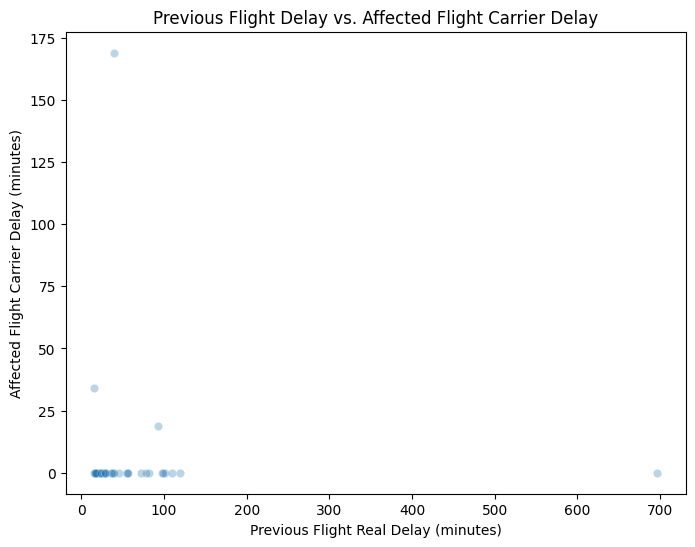

In [7]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=lagged,
    x="lag_delay_minutes",
    y="CARRIER_DELAY",
    alpha=0.3
)
plt.title("Previous Flight Delay vs. Affected Flight Carrier Delay")
plt.xlabel("Previous Flight Real Delay (minutes)")
plt.ylabel("Affected Flight Carrier Delay (minutes)")
plt.show()

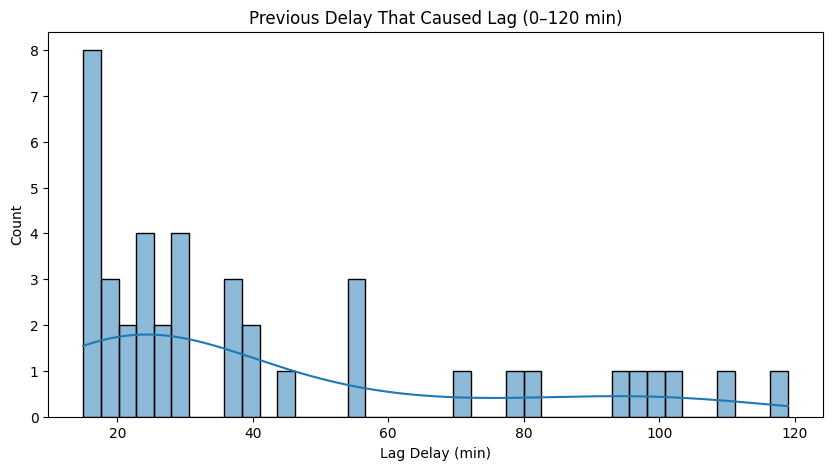

In [8]:
plt.figure(figsize=(10,5))
sns.histplot(lagged[lagged["lag_delay_minutes"] < 120]["lag_delay_minutes"], bins=40, kde=True)
plt.title("Previous Delay That Caused Lag (0–120 min)")
plt.xlabel("Lag Delay (min)")
plt.ylabel("Count")
plt.show()

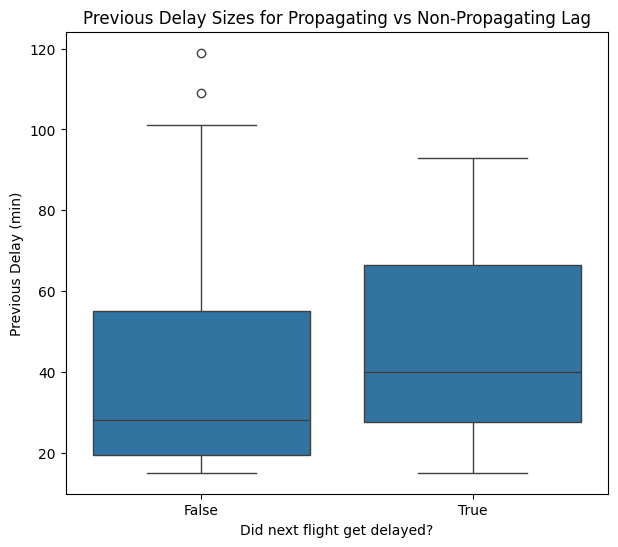

In [9]:
lagged["was_delayed"] = lagged["CARRIER_DELAY"] > 0

plt.figure(figsize=(7,6))
sns.boxplot(
    data=lagged[lagged["lag_delay_minutes"] < 120],
    x="was_delayed",
    y="lag_delay_minutes"
)
plt.title("Previous Delay Sizes for Propagating vs Non-Propagating Lag")
plt.xlabel("Did next flight get delayed?")
plt.ylabel("Previous Delay (min)")
plt.show()